# Pretrained CNN - Feature Extraction with Data Augmentation
<br>In diesem Code Notebook behandeln wir Feature Extraction mit Data Augmentation, dies sollte nur auf Server mit GPU laufen.

### Load Packages

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras

import matplotlib
import matplotlib.pyplot as plt # plotting library
%matplotlib inline
matplotlib.get_backend()

2023-05-04 18:21:11.019035: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-04 18:21:11.021651: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-04 18:21:11.068136: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-04 18:21:11.069832: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 18:21:11.765081: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

'module://matplotlib_inline.backend_inline'

### Load Path Files

In [2]:

original_dataset_dir = '../data/train'

base_dir = '../data/cats_and_dogs_2k'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

### Data Preparation with Data Augmentation

In [3]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
                                                                rescale=1./255,
                                                                rotation_range=40,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True
                                                             )

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Load Convolutional Base

In [4]:
conv_base = tf.keras.applications.VGG16(weights='imagenet',
                                        include_top=False,
                                        input_shape=(150,150,3))
print(conv_base.summary())

2023-05-04 18:21:12.985748: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

### Model building

In [16]:
model = tf.keras.models.Sequential()
model.add(conv_base)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [17]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Compile model

In [18]:
model.compile(loss='binary_crossentropy',
              metrics=['acc'],
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5))

### Fit Model

In [19]:
history2 = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data= validation_generator,
    validation_steps=50
)

Epoch 1/30


/tmp/ipykernel_1910441/580763876.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model.fit_generator(
2023-05-04 20:01:23.972788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - ETA: 0s - loss: 0.0679 - acc: 0.9755

2023-05-04 20:01:56.132427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 45s 447ms/step - loss: 0.0679 - acc: 0.9755 - val_loss: 0.0951 - val_acc: 0.9730
Epoch 2/30
100/100 [==============================] - 45s 446ms/step - loss: 0.0229 - acc: 0.9920 - val_loss: 0.0921 - val_acc: 0.9770
Epoch 3/30
100/100 [==============================] - 45s 445ms/step - loss: 0.0129 - acc: 0.9970 - val_loss: 0.0964 - val_acc: 0.9750
Epoch 4/30
100/100 [==============================] - 45s 446ms/step - loss: 0.0098 - acc: 0.9965 - val_loss: 0.1171 - val_acc: 0.9740
Epoch 5/30
100/100 [==============================] - 44s 444ms/step - loss: 0.0102 - acc: 0.9960 - val_loss: 0.1303 - val_acc: 0.9760
Epoch 6/30
100/100 [==============================] - 44s 442ms/step - loss: 0.0080 - acc: 0.9975 - val_loss: 0.1523 - val_acc: 0.9740
Epoch 7/30
100/100 [==============================] - 44s 444ms/step - loss: 0.0078 - acc: 0.9965 - val_loss: 0.1281 - val_acc: 0.9790
Epoch 8/30
100/100 [==============================] - 44s 443ms/st

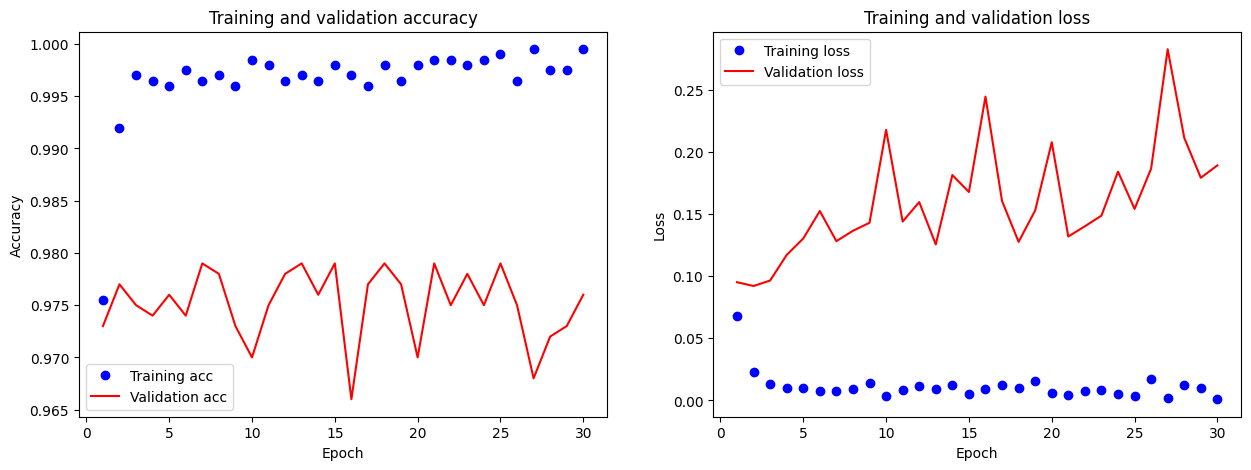

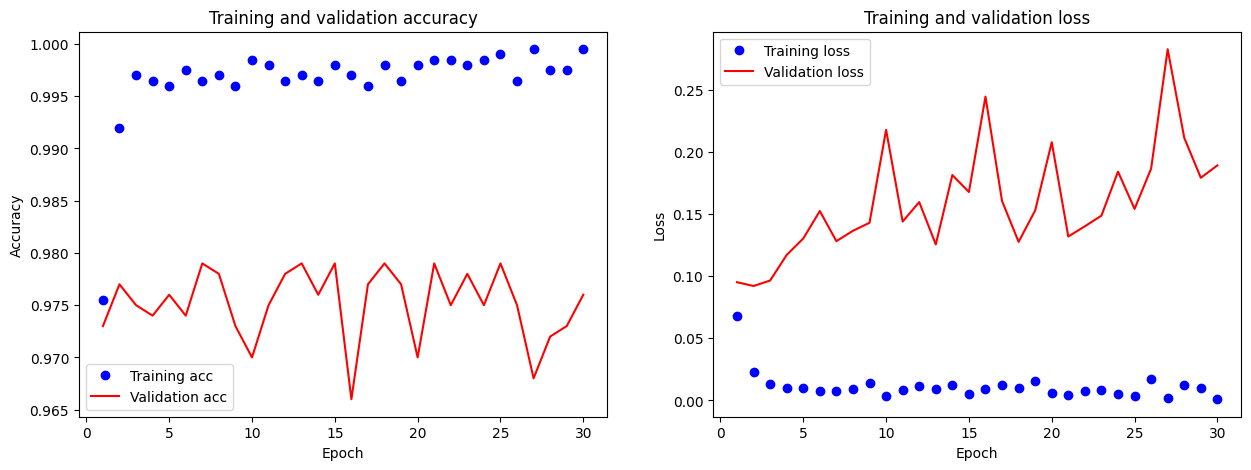

In [20]:
plot_history(history2)

### Fine_Tune

In [9]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


### Compile model

In [10]:
model.compile(loss='binary_crossentropy',
              metrics=['acc'],
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5))

### Fit Model

In [11]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data= validation_generator,
    validation_steps=50
)

Epoch 1/30


/tmp/ipykernel_1910441/3385942099.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2023-05-04 18:57:45.464187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - ETA: 0s - loss: 0.0218 - acc: 0.9915

2023-05-04 18:58:17.363107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 45s 444ms/step - loss: 0.0218 - acc: 0.9915 - val_loss: 0.1498 - val_acc: 0.9750
Epoch 2/30
100/100 [==============================] - 44s 444ms/step - loss: 0.0201 - acc: 0.9940 - val_loss: 0.1274 - val_acc: 0.9770
Epoch 3/30
100/100 [==============================] - 44s 445ms/step - loss: 0.0144 - acc: 0.9950 - val_loss: 0.1405 - val_acc: 0.9740
Epoch 4/30
100/100 [==============================] - 45s 447ms/step - loss: 0.0248 - acc: 0.9930 - val_loss: 0.1454 - val_acc: 0.9740
Epoch 5/30
100/100 [==============================] - 44s 444ms/step - loss: 0.0125 - acc: 0.9965 - val_loss: 0.1187 - val_acc: 0.9800
Epoch 6/30
100/100 [==============================] - 45s 446ms/step - loss: 0.0123 - acc: 0.9965 - val_loss: 0.1581 - val_acc: 0.9770
Epoch 7/30
100/100 [==============================] - 45s 446ms/step - loss: 0.0179 - acc: 0.9930 - val_loss: 0.2006 - val_acc: 0.9670
Epoch 8/30
100/100 [==============================] - 45s 446ms/st

In [12]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    # Plot training and validation accuracy per epoch
    ax1.plot(epochs, acc, 'bo', label='Training acc')
    ax1.plot(epochs, val_acc, 'r-', label='Validation acc')
    ax1.set_title('Training and validation accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    # Plot training and validation loss per epoch
    ax2.plot(epochs, loss, 'bo', label='Training loss')
    ax2.plot(epochs, val_loss, 'r-', label='Validation loss')
    ax2.set_title('Training and validation loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    return fig

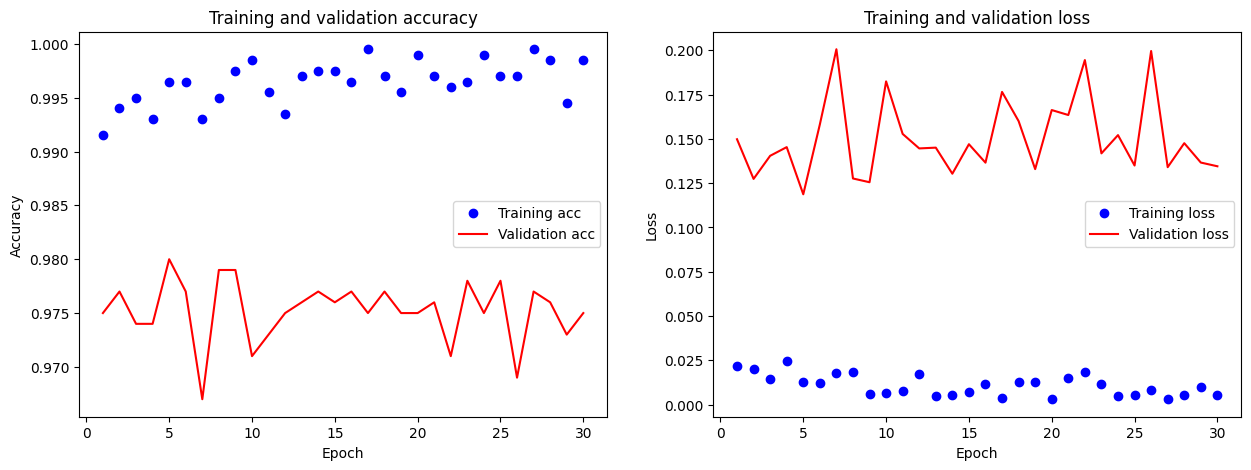

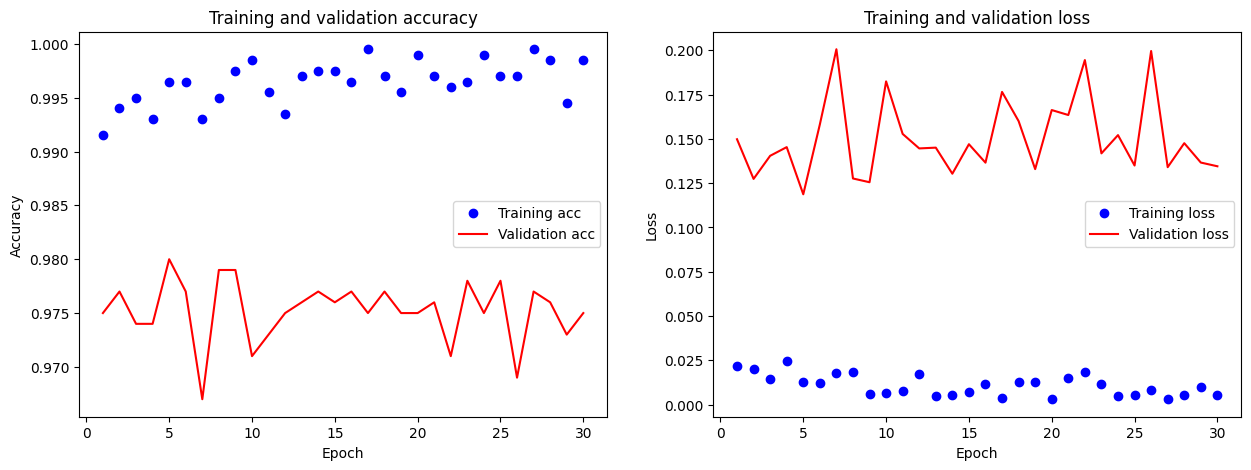

In [14]:
plot_history(history)

### Save model

In [ ]:
model.save('cats_and_dogs_pretrained_with_fine_tuning.h5')